# NammaMetro Ridership EDA

In [717]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Let's take a closer look at what NammaMetro has been dishing out so far

In [718]:
filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 0 to 32
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Record Date        33 non-null     object
 1   Total Smart Cards  33 non-null     int64 
 2   Stored Value Card  33 non-null     int64 
 3   One Day Pass       33 non-null     int64 
 4   Three Day Pass     33 non-null     int64 
 5   Five Day Pass      33 non-null     int64 
 6   Tokens             33 non-null     int64 
 7   Total NCMC         33 non-null     int64 
 8   Group Ticket       33 non-null     int64 
 9   Total QR           33 non-null     int64 
 10  QR NammaMetro      33 non-null     int64 
 11  QR WhatsApp        33 non-null     int64 
 12  QR Paytm           33 non-null     int64 
dtypes: int64(12), object(1)
memory usage: 3.6+ KB


In [719]:
df.tail(10)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
23,24-11-2024,232570,231332,1080,115,43,273790,4558,734,169201,44895,94343,29963
24,25-11-2024,455998,455065,673,70,190,219702,11454,645,189697,53591,100228,35878
25,26-11-2024,479416,478599,546,62,209,196546,12319,661,180323,50024,94852,35447
26,27-11-2024,478277,477713,321,61,182,199749,12191,618,179547,50155,94551,34841
27,28-11-2024,464165,463303,597,75,190,200081,11859,785,183068,50567,97001,35500
28,29-11-2024,459914,458983,644,77,210,205777,11220,780,181937,50383,97180,34374
29,30-11-2024,391894,390520,1180,142,52,234756,8428,1045,178402,47520,97787,33095
30,01-12-2024,154334,153369,816,110,39,220404,4122,600,196242,52072,107955,36215
31,02-12-2024,409724,409132,340,90,162,187408,10402,872,177203,50580,93367,33256
32,03-12-2024,461996,461278,429,95,194,198932,12319,325,155053,51715,65741,37597


The [Namma Metro Ridership stats page](https://english.bmrc.co.in/ridership/) publishes a breakdown of payment methods used daily by passengers entering the system.
![ridership_plot](nammametro_datapage.png)

In [720]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1)
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

df[['Record Date', 'Day of Week', 'Total Riders']].tail(7)


,Record Date,Day of Week,Total Riders
26,2024-11-27,Wednesday,870382
27,2024-11-28,Thursday,859958
28,2024-11-29,Friday,859628
29,2024-11-30,Saturday,814525
30,2024-12-01,Sunday,575702
31,2024-12-02,Monday,785609
32,2024-12-03,Tuesday,828625


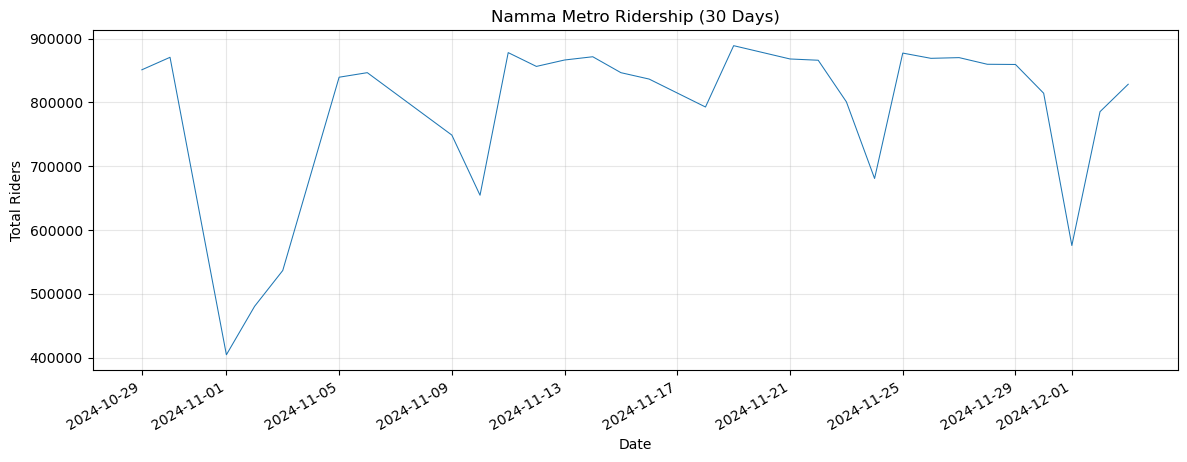

In [721]:
df.tail(30).plot(figsize=(14,5), 
                    kind='line', 
                    x='Record Date', 
                    xlabel='Date', 
                    y='Total Riders', 
                    ylabel='Total Riders', 
                    title='Namma Metro Ridership (30 Days)', 
                    legend=False,
                    linestyle='-',  # Solid line
                    linewidth=0.75)  # Thicker line
plt.grid(True, alpha=0.3)  # Optional: adds a light grid
plt.show()

### Let's make a cleaner graph for the last 14 days of available data.

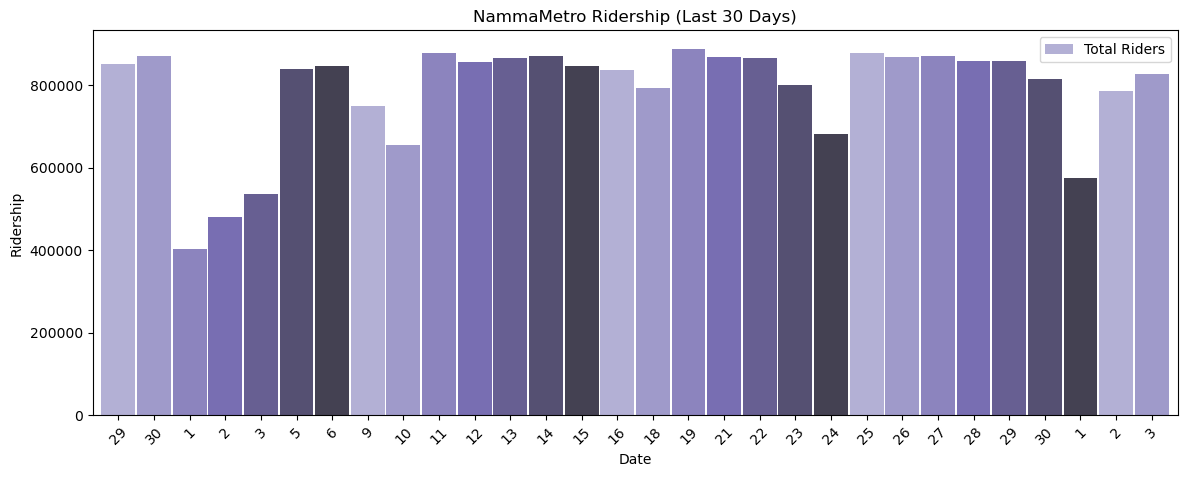

In [722]:
number_of_days = 30
Last_N_Days = df[['Record Date', 'Total Riders']].tail(number_of_days)
Last_N_Days['Record Date'] = pd.to_datetime(Last_N_Days['Record Date'], format='%d-%m-%Y').dt.day
Last_N_Days.plot(x='Record Date', 
                 y='Total Riders', 
                 kind='bar', 
                 xlabel='Date', 
                 ylabel='Ridership', 
                 title='NammaMetro Ridership (Last 30 Days)', 
                 figsize=(14,5), 
                 width=0.95,
                 legend=True,
                 color=sns.color_palette('Purples_d', 7),
                 rot=45)
plt.show()

### Note the gaps in the data. 
NammaMetro fails to report ridership numbers on some days. Is someone updating the page manually?! 
Let's get a better understanding of that missing data.

In [723]:
# Generate a dataframe with last n sequential dates

from datetime import date, timedelta

start_date = date.today() - timedelta(number_of_days, 0, 0)
dates = pd.DataFrame({'Record Date': [str(start_date+timedelta(n)) for n in range(number_of_days)]})
dates['Record Date'] = pd.to_datetime(dates['Record Date'], format='%Y-%m-%d')

print(f"We will examine data for an interval of {number_of_days} days between {dates['Record Date'].min().strftime('%d-%m-%Y')} and {dates['Record Date'].max().strftime('%d-%m-%Y')}.")

We will examine data for an interval of 30 days between 04-11-2024 and 03-12-2024.


In [725]:
# Merge the original df with the column of dates to get all values including nulls

Last_N_Days = df.merge(dates, how='right', on='Record Date')
Last_N_Days.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
Last_N_Days.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

formatted_dates = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.day
formatted_numbers = Last_N_Days.loc[:, 'Smart Cards':'Total Riders'].astype('Int64')

Last_N_Days = pd.concat([formatted_dates, formatted_numbers, Last_N_Days['Day of Week']], axis=1)
Last_N_Days

,Record Date,Smart Cards,Tokens,NCMC,Group Ticket,QR,Total Riders,Day of Week
0,4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1,5,456576,197699,11202,338,173838,839653,Tuesday
2,6,464487,201316,11459,224,169298,846784,Wednesday
3,7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
4,8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
5,9,324351,242952,3145,477,177960,748885,Saturday
6,10,175159,262652,4351,805,211556,654523,Sunday
7,11,464358,218340,11685,964,182878,878225,Monday
8,12,475075,193049,12160,605,175699,856588,Tuesday
9,13,472363,204021,12056,1090,177117,866647,Wednesday


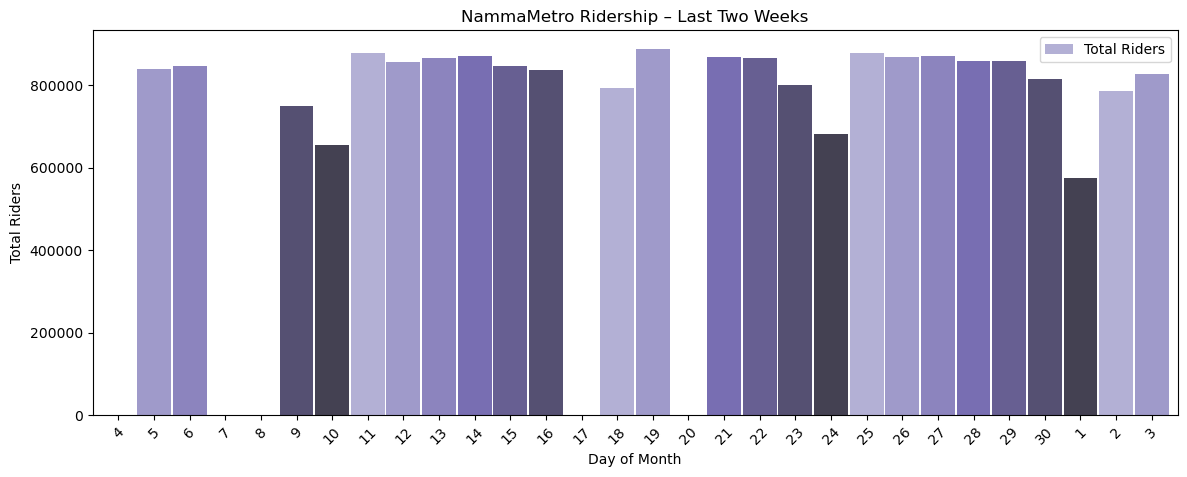

In [726]:
Last_N_Days.plot(x='Record Date',
                 y='Total Riders',
                 kind='bar',
                 xlabel='Day of Month',
                 ylabel='Total Riders',
                 title='NammaMetro Ridership – Last Two Weeks', 
                 figsize=(14,5),
                 width=0.95,
                 color=sns.color_palette('Purples_d', 7),
                 legend=True,
                 rot=45)
plt.show()

### Looks like a mouth with a few broken teeth!

What sort of data imputations makes sense here? When the dataset grows large enough over several months, I would fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.

In [727]:
Last_N_Days = Last_N_Days.melt(
                    id_vars=['Record Date'], 
                    value_vars=['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR'], 
                    var_name='Access System', 
                    value_name='Count').sort_values(by=['Record Date', 'Access System'])
Last_N_Days = Last_N_Days[['Record Date', 'Access System', 'Count']].reset_index()
Last_N_Days.tail(20)

,index,Record Date,Access System,Count
130,113,27,Group Ticket,618
131,83,27,NCMC,12191
132,143,27,QR,179547
133,23,27,Smart Cards,478277
134,53,27,Tokens,199749
135,114,28,Group Ticket,785
136,84,28,NCMC,11859
137,144,28,QR,183068
138,24,28,Smart Cards,464165
139,54,28,Tokens,200081


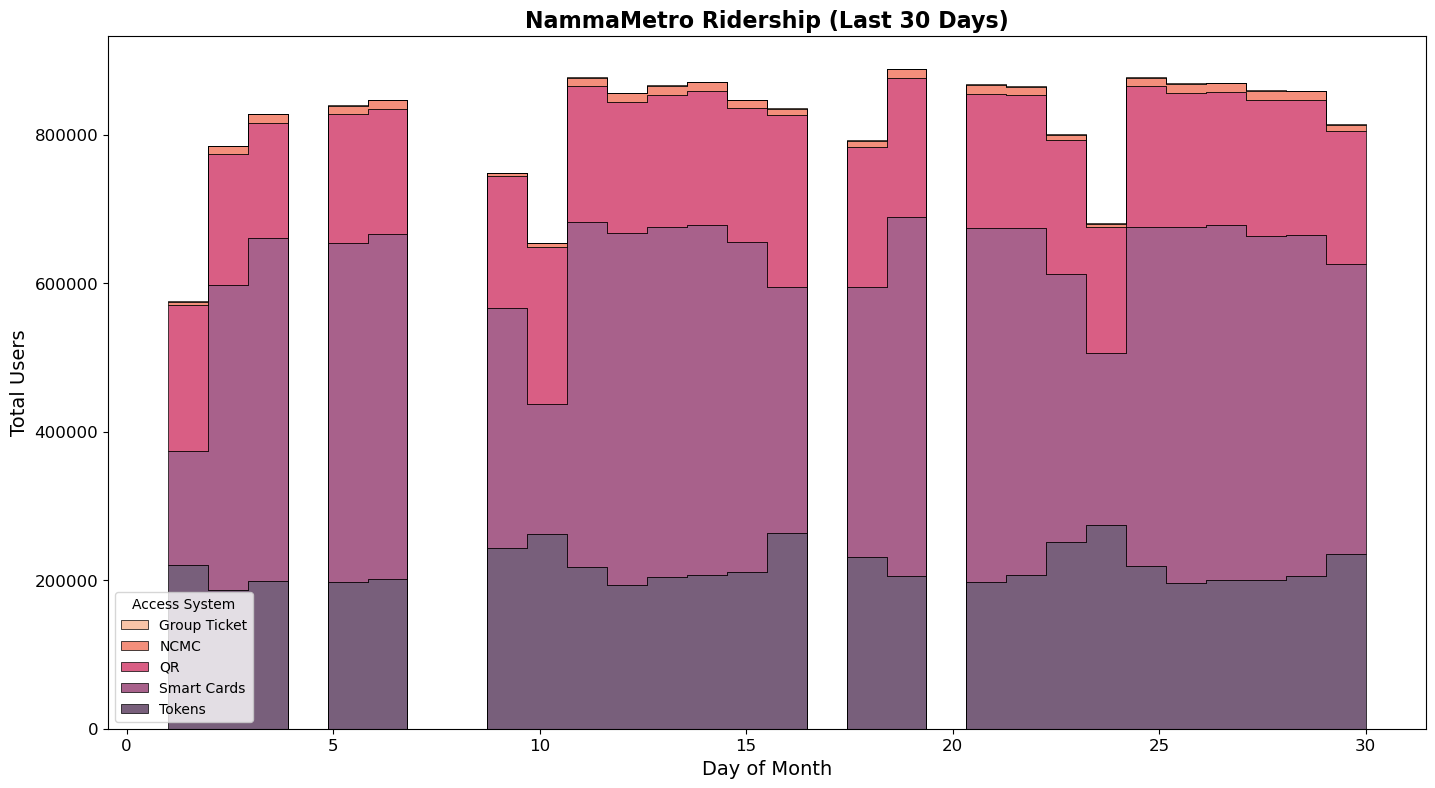

In [728]:
plt.figure(figsize=(17,9))
sns.histplot(data=Last_N_Days,
             x='Record Date',
             weights='Count',
             bins=number_of_days,
             hue='Access System',
             multiple='stack', 
             element='step',
             palette='rocket_r',
             legend=True, 
             common_norm=True,
             stat='count',
             linewidth=0.5,
             alpha=0.7)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Total Users', fontsize=14)
plt.title(f'NammaMetro Ridership (Last {number_of_days} Days)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [729]:
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()


Day of Week
Saturday     6
Tuesday      6
Sunday       5
Monday       5
Wednesday    4
Friday       4
Thursday     3
Name: count, dtype: int64

In [731]:
weekly_average = df.merge(dates, how='right', on='Record Date')
weekly_average.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
weekly_average.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

weekly_average = weekly_average.groupby('Day of Week')[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']].mean()
weekly_average = weekly_average.loc[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

for col in ['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']:
    weekly_average[col] = pd.to_numeric(weekly_average[col].fillna(0), errors='coerce').round().astype('Int64')

weekly_average

,Smart Cards,Tokens,NCMC,Group Ticket,QR
Day of Week,,,,,
Sunday,187354,252282,4344,713,192333
Saturday,352035,248349,6792,931,192190
Friday,457224,207898,11012,924,180495
Thursday,470513,201993,11924,654,181573
Wednesday,471709,201695,11902,644,175321
Tuesday,471409,198266,12066,538,174369
Monday,423362,214272,10594,828,184512


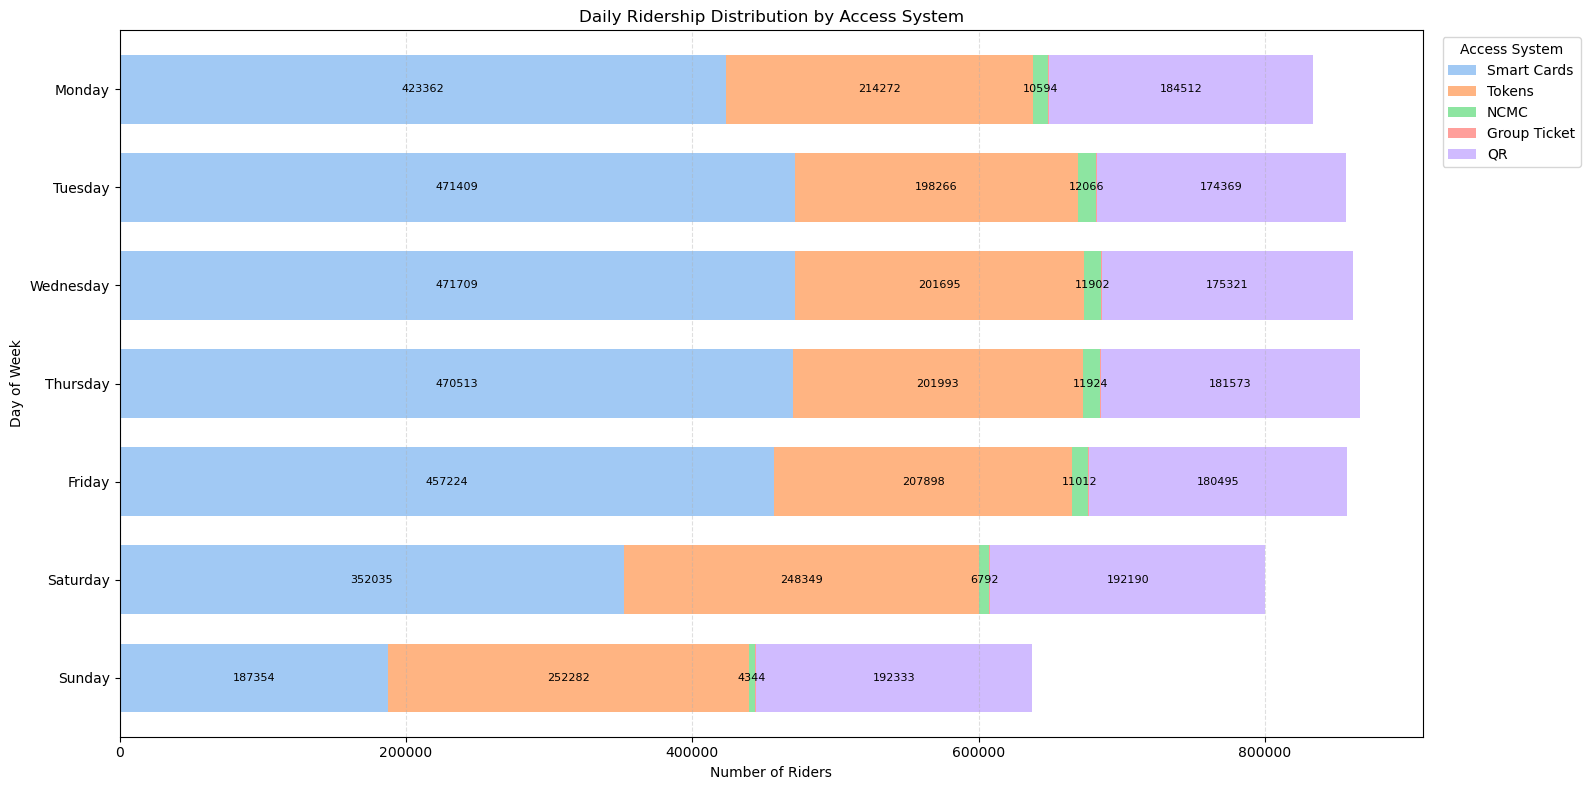

In [732]:
ax = weekly_average.plot(kind='barh', 
                         stacked=True,
                         color=sns.color_palette('pastel', 5),
                         figsize=(16, 8),
                         width=0.7,
                         rot=0)

plt.title('Daily Ridership Distribution by Access System')
plt.ylabel('Day of Week')
plt.xlabel('Number of Riders')
plt.legend(title='Access System', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Only show labels for segments larger than 1%
for c in ax.containers:
    labels = ['%.0f' % v if v >= 1000 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=8)

plt.tight_layout()
plt.show()